In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [4]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [5]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

In [6]:
def generate_uniform_circle_data(n, center, radius):
    length = np.sqrt(np.random.uniform(0, 1, n)) * radius
    angle = np.pi * np.random.uniform(
        0, 2, n
    )  # cover full range from 0 to 2pi
    x = length * np.cos(angle) + center[0]
    y = length * np.sin(angle) + center[1]
    return np.vstack((x, y)).T


def get_circle_idx(X, center, radius):
    h, k = center
    idx = np.sqrt((X[:, 0] - h) ** 2 + (X[:, 1] - k) ** 2) < radius
    return idx

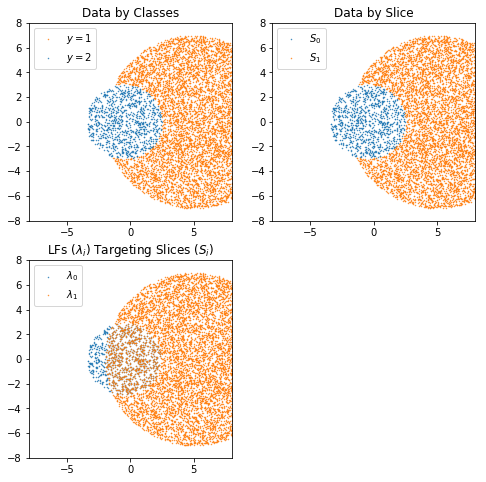

In [7]:
from synthetics_utils import shuffle_matrices

config = {
 'N': 10000,
 'mus': np.array([[-0.5,  0], [5, 0]]),
 'variances': [3, 7],
#  'mus': np.array([[0.5,  0], [5, 0]]),
#  'variances': [2.2, 7],
 'labels': [2, 1],
 'props': [0.1, 0.9],
 'accs': np.array([0.99, 0.99]),
 'covs': [('recall', 0.99), ('recall', 0.99), ('recall', 0.99)],
 'mv_normal': False
}

def generate_simple_data(config, x_var=None, x_range=None, verbose=False, return_overlap=False):
    centers = config['mus']
    radii = config['variances']
    class_props = config['props']
    N = config['N']
    labels = config['labels']

    # Set slice 1
    n_per_slice = [int(N*prop) for prop in class_props]
    slice_1 = generate_uniform_circle_data(
        n_per_slice[1], 
        centers[1], 
        radii[1]
    )

    # get idx for slice 0 within slice 1
    slice_0_idx = get_circle_idx(slice_1, tuple(centers[0]), radii[0])

    # remove slice 0 idx from slice 1
    # NOTE: because we remove the slice, if the variances are not 
    # proportional to the slice size, the original props will not be maintained
    slice_1 = slice_1[np.logical_not(slice_0_idx)]
    n_per_slice[1] = len(slice_1)

    # Set slice 0
    slice_0 = generate_uniform_circle_data(
        n_per_slice[0], 
        centers[0], 
        radii[0]
    )

    # combine slices
    Xu = [slice_0, slice_1] # data points
    Yu = [label * np.ones(n) for n, label in zip(n_per_slice, labels)] # class labels
    Cu = [i * np.ones(n) for i, n in enumerate(n_per_slice)] # slice labels

    X, Y, C = shuffle_matrices([np.vstack(Xu), np.hstack(Yu), np.hstack(Cu)])
    
    # generate label matrix
    L = np.zeros((sum(n_per_slice), 2))

#     set LF0 to be a little smaller than the slice itself
#     size_delta = 0.5 #TODO: make a param 
    size_delta = 0.1
    lf_0_idx = get_circle_idx(X, tuple(centers[0]), radii[0] - size_delta)
    L[lf_0_idx, 0] = labels[0]
    
    # set LF1 to perfectly target slice
    lf_1_idx = get_circle_idx(X, tuple(centers[1]), radii[1])
    L[lf_1_idx, 1] = labels[1]

    overlap_idx = np.logical_and(lf_0_idx, lf_1_idx)
    
    if return_overlap:
        return X, Y, C, L, overlap_idx
    
    return X, Y, C, L


X, Y, C, L, overlap_idx = generate_simple_data(config, return_overlap=True)
# mask = C==1
mask = overlap_idx
# X = X[mask]
# Y = Y[mask]
# L = L[mask]
# C = C[mask]

visualize_data(X, Y, C, L)

In [8]:
np.unique(L, return_counts=True), np.unique(Y, return_counts=True)

((array([0., 1., 2.]), array([7998, 8509,  943])),
 (array([1., 2.]), array([7725, 1000])))

In [9]:
np.unique(L.sum(axis=1), return_counts=True)

(array([0., 1., 2., 3.]), array([  17, 7765,  199,  744]))

In [10]:
from simulate import simulate, experiment_config
split_idx = int(len(X) * experiment_config["train_prop"])
X = torch.from_numpy(X.astype(np.float32))
L = L.astype(np.float32)
Y = Y.astype(np.float32)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]  # no gt train data!
L_train, L_test = L[:split_idx], L[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]
overlap_train, overlap_test = overlap_idx[:split_idx], overlap_idx[split_idx:]

[1.0, 0.9045667447306791]


(array([ 164.,    0.,    0.,    0.,    0.,  588.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   15.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 6213.]),
 array([0.00276243, 0.03563675, 0.06851106, 0.10138538, 0.1342597 ,
        0.16713401, 0.20000833, 0.23288265, 0.26575697, 0.29863128,
        0.3315056 , 0.36437992, 0.39725423, 0.43012855, 0.46300287,
        0.49587718, 0.5287515 , 0.56162582, 0.59450013, 0.62737445,
        0.66024877, 0.69312308, 0.7259974 , 0.75887172, 0.79174603,
        0.82462035, 0.85749467, 0.89036898, 0.9232433 , 0.95611762,
        0.98899193]),
 <a list of 30 Patch objects>)

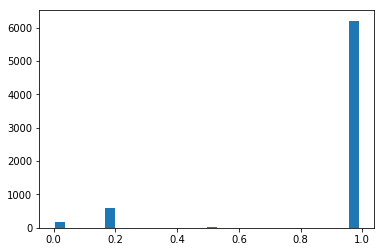

In [11]:
accs = []
from metal.metrics import accuracy_score
for lf_idx in range(L_train.shape[1]):
    voted_idx = L_test[:, lf_idx] != 0
    accs.append(accuracy_score(L_test[voted_idx, lf_idx], Y_test[voted_idx]))

print (accs)

# accs = np.array([0.9, 0.1]).astype(np.float32)
from metal.contrib.slicing.experiment_utils import generate_weak_labels
Y_tilde_accs = generate_weak_labels(L_train, np.array(accs))
plt.hist(Y_tilde_accs[:, 0], 30)

(array([ 164.,    0.,    0.,    0.,  588.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   15.,    0.,    0.,    0.,
           0.,    0., 6213.]),
 array([0.17362233, 0.18739415, 0.20116596, 0.21493778, 0.2287096 ,
        0.24248141, 0.25625323, 0.27002504, 0.28379686, 0.29756867,
        0.31134049, 0.32511231, 0.33888412, 0.35265594, 0.36642775,
        0.38019957, 0.39397139, 0.4077432 , 0.42151502, 0.43528683,
        0.44905865, 0.46283047, 0.47660228, 0.4903741 , 0.50414591,
        0.51791773, 0.53168954, 0.54546136, 0.55923318, 0.57300499,
        0.58677681]),
 <a list of 30 Patch objects>)

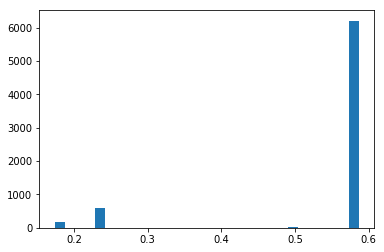

In [12]:
Y_tilde_metal = generate_weak_labels(L_train)
plt.hist(Y_tilde_metal[:, 0], 30)

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [13]:
from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

model_configs = {
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 1.0, # NOTE: slice weight 1.0 means we are only backprop on L_head
            "L_weights": None
        },
#         "input_module_class": LinearModule,
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

In [14]:
from simulate import train_models

# DEBUG: gt labels for training [prob_1, prob2]
Y_cat = np.zeros((Y_train.shape[0], 2))
Y_cat[:,0] = Y_train == 1
Y_cat[:,1] = Y_train == 2
Y_cat = Y_cat.astype(np.float32)

config['accs'] = np.array(accs)
# config['accs'] = np.array([1.0, 1.0])
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = None
experiment_config['num_trials'] = 1
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 20
experiment_config['seed'] = 222

trained_models = train_models(
    X_train,
    L_train,
    Y_tilde_accs,
    (X_test, Y_test),
    model_configs,
    experiment_config["train_kwargs"],
    verbose=experiment_config["verbose"],
    seed=experiment_config.get("seed", None)
)


---------- Training AttentionModel ----------
Slice Heads:
Reweighting: True
L_weights: tensor([[1.],
        [1.]])
Slice Weight: 1.0
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
)
L_head: Linear(in_features=5, out_features=2, bias=False)
Y_head: Linear(in_features=10, out_features=2, bias=False)
Criteria: BCEWithLogitsLoss() SoftCrossEntropyLoss()
Hardcoding 2 -> cat labels
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.016	Dev accuracy: 0.617
[E:1]	Train Loss: 0.004	Dev accuracy: 0.885
[E:2]	Train Loss: 0.003	Dev accuracy: 0.885
[E:3]	Train Loss: 0.003	Dev accuracy: 0.885
[E:4]	Train Loss: 0.002	Dev accuracy: 0.885
Saving model at iteration 5 with best score 0.885
[E:5]	Train Loss: 0.002	Dev accuracy: 0.885
[E:6]	Train Loss: 0.002	Dev accuracy

In [15]:
import torch.nn.functional as F
# X_test_L_head = X_train
# L_test_L_head = L_train
# overlap_test_L_head = overlap_train

X_test_L_head = X_test
L_test_L_head = L_test
overlap_test_L_head = overlap_test


slice_preds = F.sigmoid(
    trained_models['AttentionModel'].forward_L(X_test_L_head)
).detach().numpy()


preds = (slice_preds > 0.5) * 1
L_gt = L_test_L_head.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.sum(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))

print ('accuracy over overlap for LF 0:', 
       accuracy_score(L_gt[overlap_test_L_head, 0], preds[overlap_test_L_head, 0]))

print ('accuracy over overlap for LF 1:', 
      accuracy_score(L_gt[overlap_test_L_head, 1], preds[overlap_test_L_head, 1]))


predicted L distribution: [ 106 1695]
accuracy over LF0: 0.9455587392550143
accuracy over LF1: 0.9879656160458453
accuracy over overlap for LF 0: 0.4230769230769231
accuracy over overlap for LF 1: 0.8910256410256411


### Compare EndModel to AttentionModel

In [16]:
model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False
    },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 0.1,
            "L_weights": None
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

Simulating: None=None


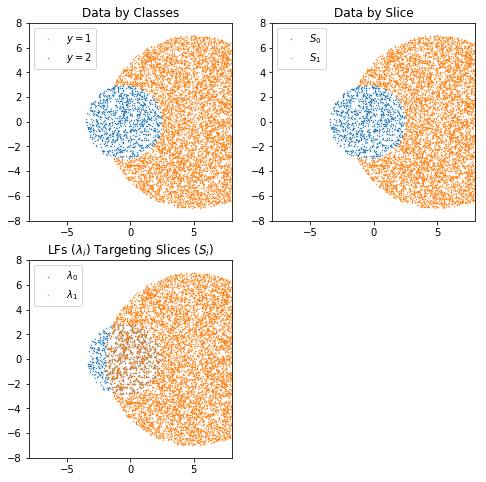

---------- Training EndModel ----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=5, out_features=2, bias=True)
)

No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.403	Dev accuracy: 0.943
[E:1]	Train Loss: 0.175	Dev accuracy: 0.947
[E:2]	Train Loss: 0.168	Dev accuracy: 0.948
[E:3]	Train Loss: 0.163	Dev accuracy: 0.951
[E:4]	Train Loss: 0.159	Dev accuracy: 0.951
Saving model at iteration 5 with best score 0.952
[E:5]	Train Loss: 0.156	Dev accuracy: 0.952
Saving model at iteration 6 with best score 0.955
[E:6]	Train Loss: 0.153	Dev accuracy: 0.955
Saving model at iteration 7 with best score 0.957
[E:7]	Train Loss: 0.151	Dev accuracy: 0.957
Saving model at iteration 8 with best score 0.962
[E:8]	Train Loss: 0.149	D

defaultdict(<function simulate.simulate.<locals>.<lambda>()>,
            {'EndModel': defaultdict(list,
                         {None: [{'S0': 0.7783783783783784,
                            'S1': 0.9980719794344473,
                            'S2': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                            'overall': 0.9747271682940839}]}),
             'AttentionModel': defaultdict(list,
                         {None: [{'S0': 0.9297297297297298,
                            'S1': 0.9993573264781491,
                            'S2': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                            'overall': 0.9919586444572085}]})})

In [17]:
from simulate import simulate, experiment_config
config['accs'] = np.array(accs)
# config['accs'] = np.array([1.0, 1.0])
experiment_config['use_weak_labels_from_gen_model'] = False
experiment_config['x_var'] = None
experiment_config['num_trials'] = 1
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['seed'] = 111
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores